## Essencial Functions and Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score



## Read data

In [3]:
from pathlib import Path
import numpy as np
import tifffile as tiff
from difflib import get_close_matches

# Main dataset directory
dataset_dir = Path('spotlite_dataset_loca1_date1_dir1')

images_dir = dataset_dir / 'images'
masks_dir = dataset_dir / 'masks'

assert images_dir.exists(), f"Image folder not found: {images_dir}"
assert masks_dir.exists(), f"Mask folder not found: {masks_dir}"

# Collect all image and mask files (multiple extensions)
image_paths = sorted(
    [*images_dir.glob('*.tif'), *images_dir.glob('*.tiff')],
    key=lambda p: p.stem
)
mask_paths = sorted(
    [*masks_dir.glob('*.tif'), *masks_dir.glob('*.tiff'),
     *masks_dir.glob('*.png'), *masks_dir.glob('*.jpg')],
    key=lambda p: p.stem
)

# Dictionary of masks by base name
mask_dict = {p.stem: p for p in mask_paths}
unused_masks = set(mask_dict.keys())

imgs_array, masks_array = [], []

for img_path in image_paths:
    stem = img_path.stem
    mask_path = None

    # 1) Exact match
    if stem in mask_dict:
        mask_path = mask_dict[stem]
        unused_masks.discard(stem)
    else:
        # 2) Approximate match
        candidates = get_close_matches(stem, mask_dict.keys(), n=1, cutoff=0.6)
        if candidates:
            sel = candidates[0]
            mask_path = mask_dict[sel]
            unused_masks.discard(sel)
        else:
            # 3) No match found; just notify and skip
            print(f"Warning: no mask found for {img_path.name}; skipping.")
            continue

    # Read image and mask
    img = tiff.imread(str(img_path))
    msk = tiff.imread(str(mask_path))

    # Check dimensions
    if img.shape[:2] != msk.shape:
        raise ValueError(
            f"Incompatible dimensions: {img_path.name} {img.shape[:2]} vs "
            f"{mask_path.name} {msk.shape}"
        )

    imgs_array.append(img)
    masks_array.append(msk)

# Remaining masks
if unused_masks:
    print("Warning: these masks were not used (no corresponding image):")
    for s in sorted(unused_masks):
        print("  ", s)

# Stack arrays
imgs = np.stack(imgs_array, axis=0)   # (N, H, W, C)
masks = np.stack(masks_array, axis=0)  # (N, H, W)

print(f'Final: {len(imgs)} pairs loaded.')
print(f'Shape of imgs: {imgs.shape}')
print(f'Shape of masks: {masks.shape}')


Final: 191 pairs loaded.
Shape of imgs: (191, 512, 512, 4)
Shape of masks: (191, 512, 512)


## Convert labels in masks

In [4]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

print(f'shape of remapped masks: {masks.shape}')

shape of remapped masks: torch.Size([191, 512, 512])


## Extract features and labels

In [5]:
N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (50069504, 4)
shape of y: torch.Size([50069504])


## Check Inbalance

Classe 0: 48,043,641 pixels (95.95%)
Classe 1: 687,567 pixels (1.37%)
Classe 2: 1,338,296 pixels (2.67%)
   class    counts    percent
0      0  48043641  95.953898
1      1    687567   1.373225
2      2   1338296   2.672876


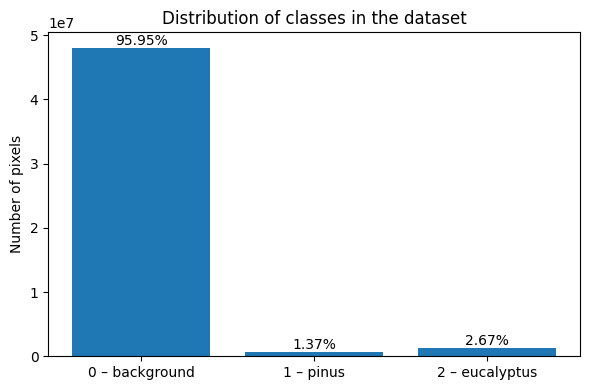

In [6]:
y = np.array(y)

y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "pinus",
    2: "eucalyptus"
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Split training/testing

In [7]:
# Ensure y is the correct array-like object
y = masks.reshape(-1)  # Restore y to its original form
y = np.array(y)
X = np.array(X, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (37552128, 4)
shape of y_train: (37552128,)
shape of X_test: (12517376, 4)
shape of y_test: (12517376,)


### Train Random Forest 

=== Stage 1: Background vs. Forest ===
              precision    recall  f1-score   support

  Background     0.9932    0.8648    0.9246  12010910
      Forest     0.2114    0.8593    0.3393    506466

    accuracy                         0.8646  12517376
   macro avg     0.6023    0.8621    0.6319  12517376
weighted avg     0.9616    0.8646    0.9009  12517376

=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===
              precision    recall  f1-score   support

       Pinus     0.9621    0.9303    0.9459    171892
  Eucalyptus     0.9648    0.9812    0.9729    334574

    accuracy                         0.9639    506466
   macro avg     0.9634    0.9557    0.9594    506466
weighted avg     0.9639    0.9639    0.9638    506466

=== Full Pipeline (3 classes) ===
              precision    recall  f1-score   support

  Background     0.9932    0.8648    0.9246  12010910
       Pinus     0.0953    0.6510    0.1663    171892
  Eucalyptus     0.3510    0.9282    0.5094    334

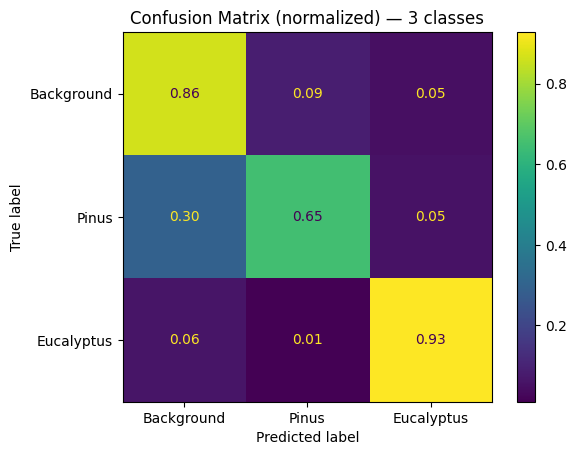

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np

def train_two_stage_rf(X, y, forest_params, species_params):
  # Stage 1: background (0) vs forest (1)
  y_forest = (y > 0).astype(int)
  forest_clf = RandomForestClassifier(**forest_params)
  forest_clf.fit(X, y_forest)

  # Stage 2: pinus (1) vs eucalyptus (2) only in forest pixels
  mask_f = (y > 0)
  X_fg, y_fg = X[mask_f], y[mask_f]
  species_clf = RandomForestClassifier(**species_params)
  species_clf.fit(X_fg, y_fg)

  return forest_clf, species_clf

def predict_two_stage_rf(forest_clf, species_clf, X):
  is_forest = forest_clf.predict(X).astype(bool)
  y_pred = np.zeros(X.shape[0], dtype=int)
  if is_forest.any():
    y_pred[is_forest] = species_clf.predict(X[is_forest])
  return y_pred

# --- balanced parameters ---
forest_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}
species_params = {
  'n_estimators': 50, 'max_depth': 20,
  'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42
}

# 1) Train using only X_train, y_train
forest_clf, species_clf = train_two_stage_rf(
  X_train, y_train,
  forest_params, species_params
)

# 2) Full prediction
y_pred_full = predict_two_stage_rf(forest_clf, species_clf, X_test)

# 3) Evaluation of Stage 1
y_forest_true = (y_test > 0).astype(int)
y_forest_pred = forest_clf.predict(X_test)
print("=== Stage 1: Background vs. Forest ===")
print(classification_report(
  y_forest_true, y_forest_pred,
  target_names=['Background', 'Forest'], digits=4
))

# 4) Evaluation of Stage 2 (isolated, only in REAL forest pixels)
X_test_fg = X_test[y_test > 0]
y_test_fg = y_test[y_test > 0]
y_pred_fg = species_clf.predict(X_test_fg)
print("=== Stage 2: Pinus vs. Eucalyptus (isolated evaluation) ===")
print(classification_report(
  y_test_fg, y_pred_fg,
  target_names=['Pinus', 'Eucalyptus'], digits=4
))

# 5) Full pipeline evaluation
print("=== Full Pipeline (3 classes) ===")
print(classification_report(
  y_test, y_pred_full,
  target_names=['Background', 'Pinus', 'Eucalyptus'], digits=4
))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_full,
    normalize='true',
    display_labels=['Background','Pinus','Eucalyptus'],
    values_format='.2f'
)
plt.title("Confusion Matrix (normalized) — 3 classes")
plt.show()